# Page Rank
von Nils Höhing, Tobias Schwarzer und Johann Rittenschober

## Inhaltsverzeichnis
1. [Gegeben](#Gegeben)
2. [PageRank](#PageRank)
3. [PageRank mit Dämpfung](#mitDämpfung)
4. [Zufallssurfermodell](#Zufallssurfermodell)
5. [PageRank als Eigenvektor](#alsEigenvektor)
5. [PageRank ohne Dämpfungsfaktor](#ohneDämpfung)
6. [Frage: Warum haben die Graphen auf Wikipedia unterschiedliche PageRanks?](#Frage)
7. [Anwendung: Twitter Influencer](#Twitter)
8. [Effizienz](#Effizienz)
9. [Iterationen in Abhängigkeit von der Genauigkeit](#Iterationen)
9. [Eigenschaften des PageRanks](#Eigenschaften)
10. [Quellenverzeichnis](#Quellen)

<a id="Gegeben"></a>
<br>

## 1. Gegeben

Die meisten Suchmachschinen im Internet bewerten ständig die Relevanz von Internet-Seiten.
Die Relevanz wird dabei unter anderem durch den sogenannten Page Rank bestimmt. Der Page Rank hängt entscheidend davon ab, wie viele Seiten auf diese Seite verlinken und wie wiederum deren Relevanz ist.<br>
Mathematisch erhält man ein riesiges lineares Gleichungssystem. In diesem Projekt sollen die mathematischen Hintergründe, Probleme und Lösungsmöglichkeiten, die mit der Bestimmung des Page Ranks verbunden sind, dargestellt und die verschiedenen Algorithmen in Sagemath implementiert und erprobt werden.
Das Ergebnis soll unter anderem grafisch dargestellt werden.


Beispiel: [Q0]
<img src="./PageRank_Example.png" width="500px">

<a id="PageRank"></a>
<br>

## 2. PageRank 
Der PageRank ist eine ursprünglich von Larry Page und Sergey Brin entwickelte Maßzahl zur Bestimmung der Relevanz einer Internet-Seite. Allerdings kann er vielfältig eingesetzt werden um Objekte, die füreinander abstimmen können, in eine Ordnung zu bringen. Der Name steht gleichermaßen für den Algorithmus zur Berechnung des PageRanks.
Wir haben eine Matrix gegeben, die die Wahrscheinlichkeit von Übergängen zu einer anderen Website präsentiert. Dabei sind $i$ (Zeile) und $j$ (Spalte) jeweils die Anzahl der Websiten. Solange nur eine Website auf eine andere verlinkt, bleibt das ganze eine langweilige Adjazenzmatrix. Interessant wird es erst sobald sie auf mehrere oder gar keine verlinkt. Im Falle, dass sie auf mehrere verlinkt wird an der entsprechenden Stellen $\frac{1}{(Anzahl\ der\ Seiten \ auf\ die\ verlinkt\ wird)}$ eingetragen. Wenn auf gar keine verlinkt wird, wird die ganze Reihe mit $\frac{1}{(Anzahl\ gesamter\ Websiten)}$ aufgefüllt.
Die so entstandene Matrix ist eine zeilenstochastische Übergangsmatrix, d.h. die Zeilensumme ergibt 1. Sie beinhaltet die Übergangswahrscheinlichkeiten zu einer anderen Website, solange der Benutzer nicht direkt eine URL eingibt.
Diese Wahrscheinlichkeit wiederum wird definiert durch $(1-d)E$ und heißt Teleportation.  $E = v^Te$, $e$ ist ein Vektor mit $1\cdot(Anzahl\ Websiten)$ und $v$ der Wahrscheinlichkeitsvektor, den wir hier verallgemeinern mit $\frac{e}{(Anzahl\ Websiten)}$.
Dadurch ergibt sich folgende Formel für die Google Matrix: 
$GM = dS + (1-d)E$<br>
[Q2] 
[Q4]

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
#import tweepy
import time

<a id="mitDämpfung"></a>
<br>

## 3. PageRank mit Dämpfung
Hier haben wir zur Berechnung eine zeilenstochastische Übergangsmatrix verwendet. Dies funktioniert analog zu einer spaltenstochastischen Matrix, der PageRank Vektor muss dann nur von der anderen Seite an die Matrix multipliziert werden.

In [2]:
# Quelle des Graphen: [Q1]
G = DiGraph({'A': [], 'B':['C'], 'C':['B'], 'D':['A','B'], 
             'E':['B', 'D', 'F'], 'F':['B', 'E'], 'G':['B', 'E'], 
             'H':['B', 'E'], 'I':['B', 'E'], 'J':['E'], 'K':['E']})

# Normaler PageRank mit Dämpfungsfaktor
# A ist die Adjazenzmatrix eines Graphen.
# p ist die Wahrscheinlichkeit einem Pfad zu folgen,
# 1-p ist also die Teleportationschance.
# converge_limit ist die Schwelle, an der der Algorithmus terminiert.

def pageRank(A, d, converge_limit):
    # Um die Wahrscheinlichkeit eines Übergangs zu repräsentieren, muss A  
    # in eine zeilenstochastische Matrix M (=Markov Matrix) umgewandelt werden
    M = Matrix(QQ, A)
    n = M.nrows()
    for index in range(M.nrows()):
        s = sum(M[index])
        if s != 0:
            M[index] = M[index] / s
        
    # pr enthält für jede Seite die Wahrscheinlichkeit, dass sich ein 
    # Nutzer auf dieser Seite befindet (=PageRank)
    # Gleichmäßige Initialisierung der Werte in den Vektoren.
    pr_old = np.zeros(n)
    pr = np.ones(n)
    
    # PageRank berechnen, bis er konvergiert ist.
    while sum(abs(pr-pr_old)) > converge_limit:
        
        pr_old = pr.copy()
        for index in range(0,n):
            # Normale Übergänge: Dieser Vektor enthält für jede Seite
            # die Wahrscheinlichkeit von dort zur Seite index zu kommen.
            transition = M[:,index]
            
            # PageRank Formel
            pr[index] = pr_old.dot(vector(transition * d)) + (1 - d) / n
    return pr / sum(pr)
    
pr = pageRank(G.adjacency_matrix(), 0.85, 0.001)
print('PageRank-Vektor:')
print(pr)

PageRank-Vektor:
[0.03272703 0.38485981 0.3429045  0.03902215 0.0807513  0.03902215
 0.01614261 0.01614261 0.01614261 0.01614261 0.01614261]


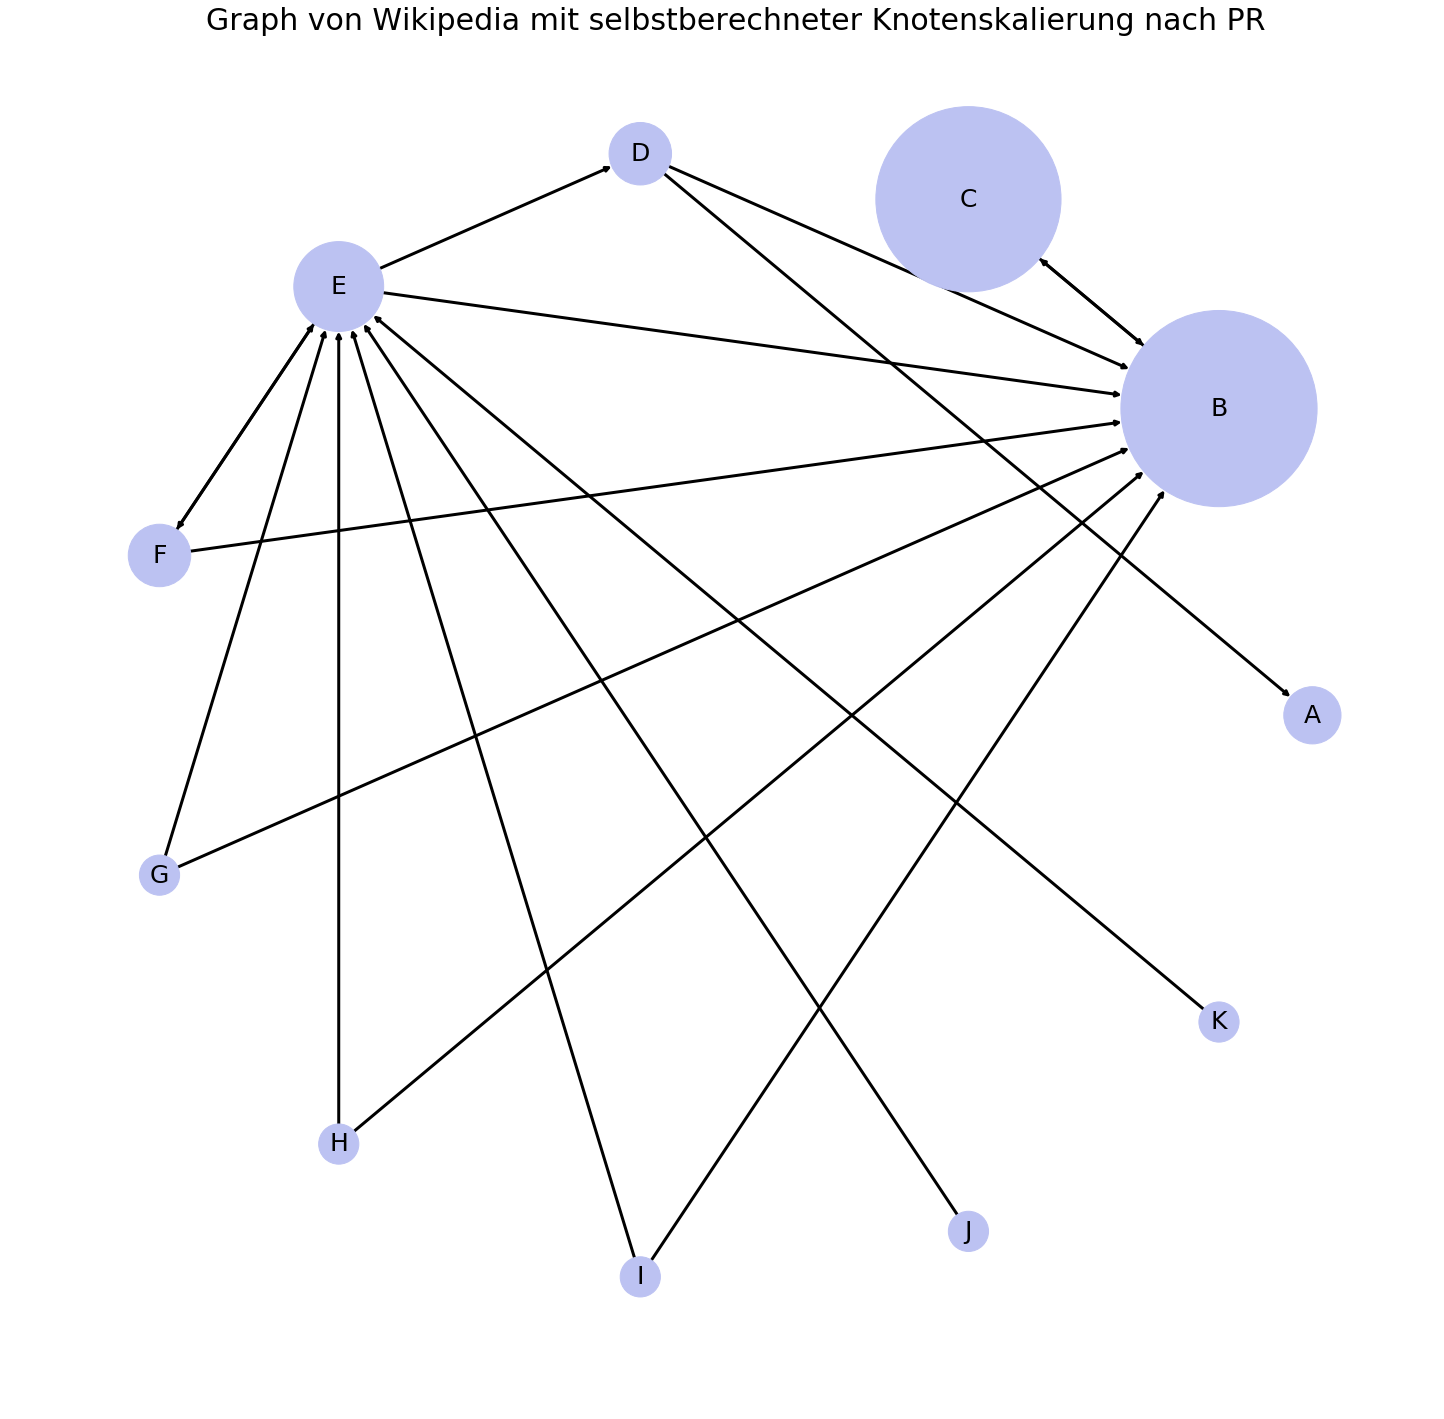

In [3]:
# Plot des Graphen mit NetworkX
T = nx.from_numpy_matrix(np.array(G.adjacency_matrix()), 
                        create_using=nx.DiGraph())
plt.figure(figsize=(25,25))
plt.title('Graph von Wikipedia mit selbstberechneter Knotenskalierung nach PR', fontsize=30)
options = {
    'node_color': '#BCC2F2',
    'width': 3,
    'with_labels': True,
    'font_weight': 'regular',
}
labeldict = {}
for index in range(len(pr)):
    labeldict[index] = chr(ord('A') + index)
nx.draw_circular(T, font_size = 25, labels = labeldict,
                 node_size=pr*100000, **options)

Der Dämpfungsfaktor wird typischerweise auf 0.85 gesetzt, da dieser Wert für Anwendungen im Netz besonders gut funktioniert. In anderen Kontexten, z.B. der Biologie haben sich jedoch auch deutlich kleinere Werte bewährt. Prinzipiell führt ein kleinerer Dämpfungsfaktor zu zu einer homogeneren Verteilung des PageRanks im System, wenn der Kontrast im System zu gering ist, kann $d$ also erhöht werden.

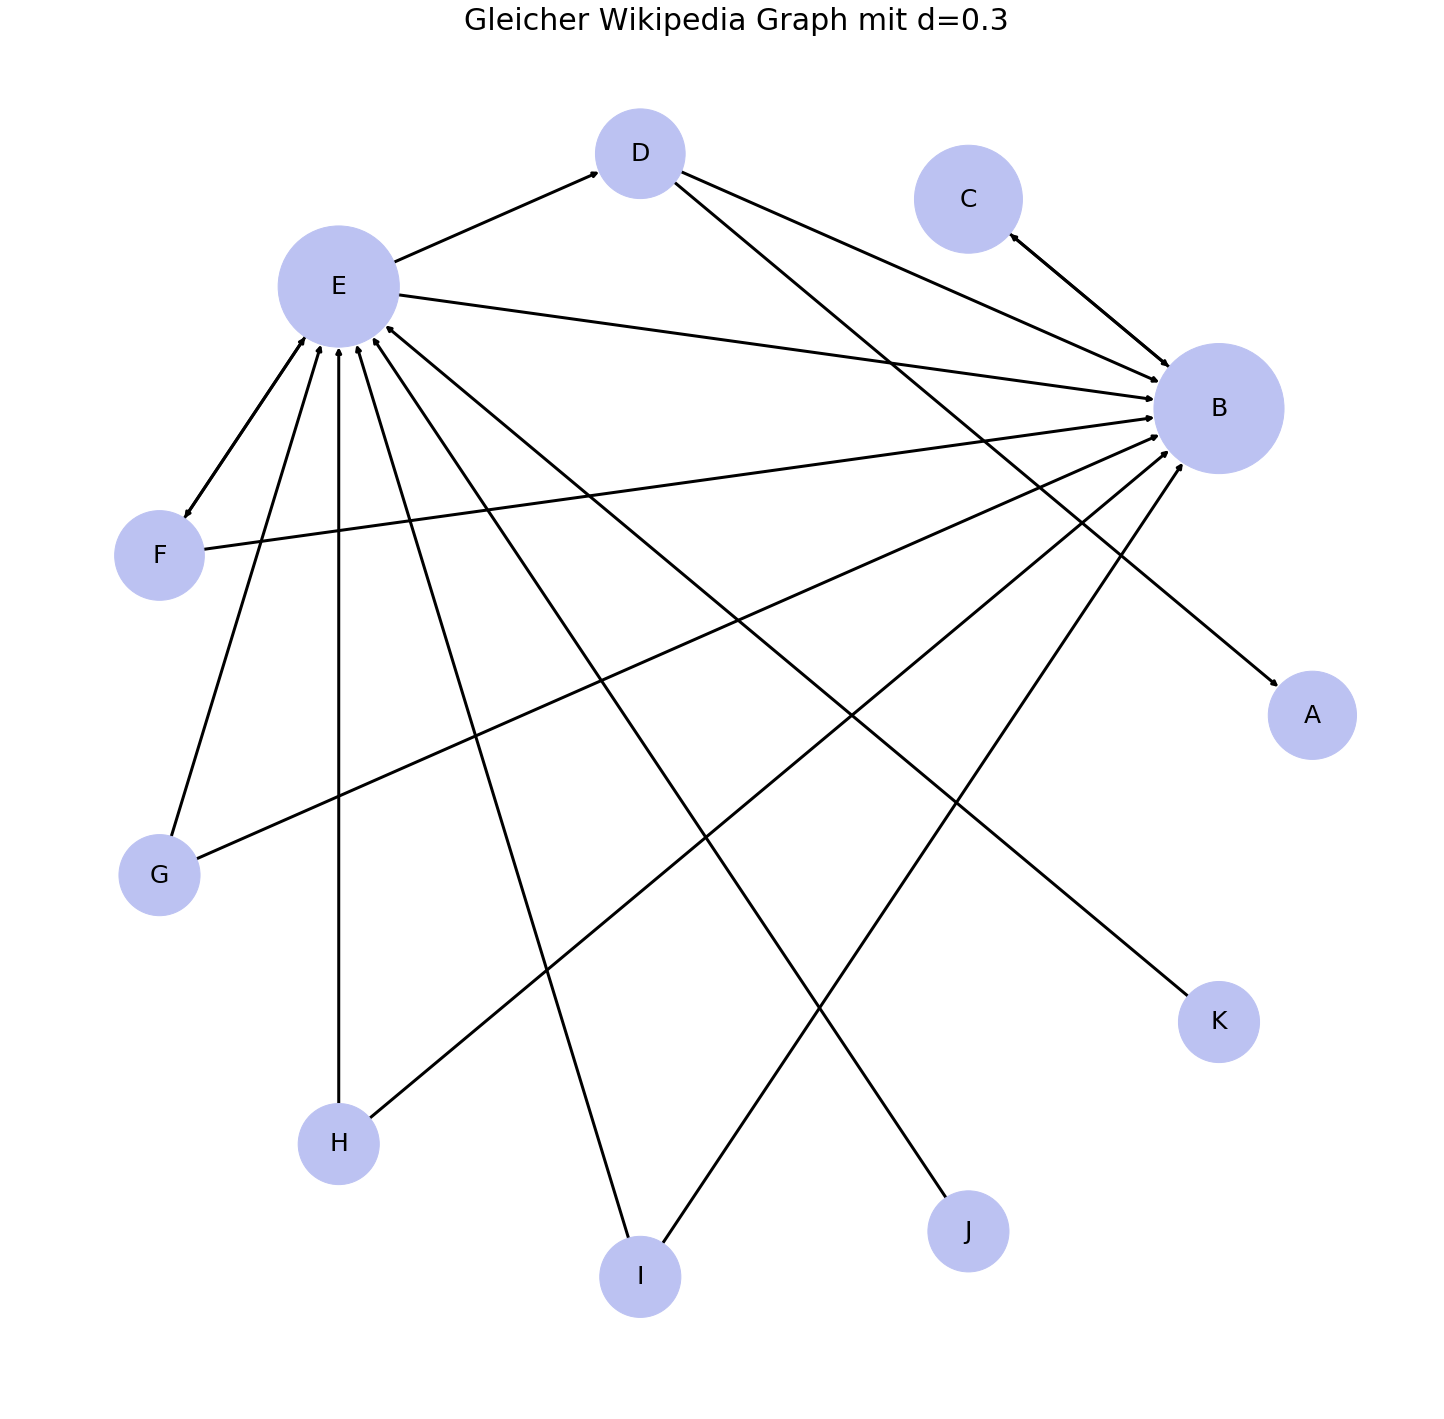

In [4]:
# PageRank mit kleinerem Dämpfungsfaktor
pr = pageRank(G.adjacency_matrix(), 0.3, 0.001)
T = nx.from_numpy_matrix(np.array(G.adjacency_matrix()), 
                        create_using=nx.DiGraph())
plt.figure(figsize=(25,25))
plt.title('Gleicher Wikipedia Graph mit d=0.3', fontsize=30)
options = {
    'node_color': '#BCC2F2',
    'width': 3,
    'with_labels': True,
    'font_weight': 'regular',
}
labeldict = {}
for index in range(len(pr)):
    labeldict[index] = chr(ord('A') + index)
nx.draw_circular(T, font_size = 25, labels = labeldict,
                 node_size=pr*100000, **options)

<a id="Zufallssurfermodell"></a>
<br>

## 4. Zufallssurfermodell
Der auf 1 normierte PageRank einer Seite kann als Wahrscheinlichkeit angesehen werden, dass sich ein zufälliger Surfer auf dieser Seite befindet.
Dieser Zufallssurfer beginnt auf einer beliebigen Seite und wählt mit der Wahrscheinlichkeit $d$ von dort aus zufällig Links zu anderen Seiten. Sollte es sich bei der aktuellen Seite um eine Senke handeln, so wählt er vorher arbiträr irgendeine Seite aus und läuft dann von dort weiter.
Mit einer Wahrscheinlichkeit von $1-d$ teleportiert sich der Surfer auf eine beliebige Seite. Der hier implementierte Algorithmus ist äquivalent zum obigen, aber an ihm kann das Verhalten des Zufallssurfers besser demonstriert werden.

In [5]:
# Umgestellte PageRank Formel implementiert, um besseres Verständnis
# für die Normierung/Teleportation zu bekommen
def pageRank_explain(A, d, converge_limit):
    # Um die Wahrscheinlichkeit eines Übergangs zu repräsentieren, muss A  
    # in eine zeilenstochastische Matrix M (=Markov Matrix) umgewandelt werden
    M = Matrix(QQ, A)
    n = M.nrows()
    
    # Dafür werden zusätzlich die Senken, also Seiten ohne weiterführende
    # Links in einem Array gespeichert
    sinks = np.zeros(n)
    for index in range(M.nrows()):
        s = sum(M[index])
        if s != 0:
            M[index] = M[index] / s
        else: 
            # Zeilensumme ist 0, also ist Seite index eine Senke
            sinks[index] = 1

    # pr enthält für jede Seite die Wahrscheinlichkeit, dass sich ein 
    # Nutzer auf dieser Seite befindet (=PageRank)
    # Gleichmäßige Initialisierung der Werte in den Vektoren.
    pr_old = np.zeros(n)
    pr = np.ones(n)
    
    while sum(abs(pr-pr_old)) > converge_limit:
        
        pr_old = pr.copy()
        for index in range(0,n):
            # Für jede Seite wird jetzt berechnet, wie wahrscheinlich es
            # ist, diese von den anderen Seiten aus zu erreichen:
                
            # Beim zufälligen Teleportieren kann die Seite von jeder
            # anderen Seite aus mit gleicher Wahrscheinlichkeit erreicht
            # werden
            teleport = np.ones(n) / float(n)
            
            # Falls der Zufallssurfer in einer Senke ist, wählt er als 
            # nächstes eine zufällige Seite.
            # Deshalb gibt es für jede Senke eine 1/n Chance, dass 
            # Seite index als nächstes ausgewählt wird
            escape_sink = sinks / float(n)
            
            # Normale Übergänge: Dieser Vektor enthält für jede Seite
            # die Wahrscheinlichkeit von dort zur Seite index zu kommen.
            transition = M[:,index]
            
            # Die Summe aller drei Vektoren wird mit dem alten PageRank-
            # Vektor multipliziert. Dieser enthält für jede Seite die 
            # Wahrscheinlichkeit, dass der Zufallssurfer sich auf dieser 
            # befindet. Also summiert das Vektorprodukt die Wahrscheinlich-
            # keiten auf, dass der Zufallssurfer auf auf einer Seite j war und 
            # dann auf die Seite index kommt, insgesamt also genau die Wahr-
            # scheinlichkeit jetzt auf Seite index zu sein.
            pr[index] = pr_old.dot(d * (escape_sink + vector(transition)) 
                                   + (1-d) * teleport)
    return pr / sum(pr)
    
pr = pageRank_explain(G.adjacency_matrix(), 0.85, 0.001)
print('PageRank-Vektor:')
print(pr)

PageRank-Vektor:
[0.03278149 0.38442009 0.34289114 0.03908709 0.08088569 0.03908709
 0.01616948 0.01616948 0.01616948 0.01616948 0.01616948]


<a id="alsEigenvektor"></a>
<br>

## 5. PageRank als Eigenvektor
Der Ansatz von Page und Brin beinhaltete zunächst die Idee eine Markov-Kette mit einer primitiven Übergangswahrscheinlichkeitsmatrix. Als primitiv wird eine Matrix bezeichnet, wenn sie nur nicht-negative Einträge besitzt. Wenn sie primiv ist, ist die Matrix auch irreduzibel. Das Theorem von Perron-Frobenius lautet: Wenn $A$ eine quadratische irreduzible Matrix ist, dann hat sie einen positiven realen Eigenwert $λ_1=1$, was auch der größte Eigenwert der Matrix ist. Wenn die Matrix nun auch noch positiv ist, wie in diesem Fall, dann existiert zu $λ_1$ auch ein postiver Eigenvektor. 
Dieser entspricht dem stationären Zustand der Markov Kette, erhalten durch die Power Method.
Arbeitet man mit einer zeilenstochastischen Matrix, sucht man den linken Eigenvektor: $π^TA = π^T$
Bei einer spaltenstochastischen Matrix sucht man den rechten Eigenvektor:
$Aπ=π$<br>
[Q4]
[Q5]

In [6]:
# PageRank durch Eigenvektorproblem
# A ist die Adjazenzmatrix eines Graphen.
# d ist die Wahrscheinlichkeit einem Pfad zu folgen,
# 1-d ist also die Teleportationschance.

def pageRank_EV(A, d):
    #Umwandlung in eine zeilenstochastische Matrix
    M = Matrix(RDF, A)
    n = M.nrows()
    for index in range(M.nrows()):
        s = sum(M[index])
        if s != 0:
            M[index] = M[index] / s
        else:
            M[index] = 1 / n
    #Transition Matrix        
    S = M
    
    #Komponenten für die Matrix E, die die Matrix irreduzibel macht.
    e = np.ones(n)
    eT = e.transpose()
    
    
    #Müssen sicher stellen, dass es nun auch noch einen stationären Zustand gibt.
    GM = Matrix(RDF,d*S+((1-d)*e*eT)/n)

    EV = GM.eigenvectors_left()[0][1][0]
    return EV / sum(EV);


pr = pageRank_EV(G.adjacency_matrix(), 0.85)  
print('PageRank-Vektor:')
print(pr)

PageRank-Vektor:
(0.03278149315934391, 0.3844009488135542, 0.34291028550837943, 0.03908709209996616, 0.08088569323449775, 0.03908709209996632, 0.016169479016858463, 0.016169479016858456, 0.016169479016858404, 0.01616947901685844, 0.01616947901685844)


<a id="ohneDämpfung"></a>
<br>

## 6. PageRank ohne Dämpfungsfaktor
Der Dämpfungsfaktor soll das Abfließen von PageRank in Senken (= Seiten, die nicht auf andere Seiten verlinken) verhindern. Hier wird der Algorithmus ohne Dämpfung implementiert, um die Verschiebung des Equilibriumszustands vorzuführen. Das Entfernen der Dämpfung ist prinzipiell gleichwertig dazu, d in der oberen Formel auf 1 zu setzen. Allerdings terminiert der Algorithmus dann nicht mehr unbedingt.

In [7]:
# PageRank ohne Dämpfungsfaktor zur Demonstration der 
# Gewichtsverschiebungen im Vergleich zum Algorithmus mit Dämpfung
def pageRankNoDamping(A, d, converge_limit, max_iterations):
    # A ist die Adjazenzmatrix eines Graphen.
    # converge_limit ist die Schwelle, an der der Algorithmus terminiert.
    # max_iterations ist die maximale Anzahl an iterationen, bis der 
    # Algorithmus abgebrochen wird. Wegen der fehlenden Dämpfung 
    # konvergiert der PageRank nur selten, also wird dieses zusätzliche 
    # Abbruchkriterium benötigt.

    # Um die Wahrscheinlichkeit eines Übergangs zu repräsentieren, muss A  
    # in eine zeilenstochastische Matrix M(=Markov Matrix) umgewandelt 
    # werden
    M = Matrix(QQ, A)
    n = M.nrows()

    for index in range(M.nrows()):
        s = sum(M[index])
        if s != 0:
            M[index] = M[index] / s

    # pr enthält für jede Seite die Wahrscheinlichkeit,
    # dass sich ein Nutzer auf dieser Seite befindet (=PageRank).
    # Gleichmäßige Initialisierung der Werte in den Vektoren.
    pr_old = np.zeros(n)
    pr = np.ones(n)
    
    iterations = 0
    while sum(abs(pr-pr_old)) > converge_limit and iterations < max_iterations:
        
        pr_old = pr.copy()
        for index in range(0,n):

            # Normale Übergänge: Dieser Vektor enthält für jede Seite
            # die Wahrscheinlichkeit von dort zur Seite index zu kommen.
            transition = M[:,index]

            # Pagerank ohne Dämpfung
            pr[index] = pr_old.dot(vector(transition))
        # Ohne Dämpfung ist es notwendig, den PageRank nach jeder Iteration auf 1 
        # zu normieren, da sonst ein Overflow auftreten kann.
        pr = pr/sum(pr)
        iterations+=1
            
    return pr/(sum(pr))

for iter in range(10, 60, 10):
    pr = pageRankNoDamping(G.adjacency_matrix(), 0.85, 0.001, iter)
    print('PageRank-Vektor ({0} Iterationen):'.format(iter))
    print(pr)

PageRank-Vektor (10 Iterationen):
[1.51281353e-05 3.52878884e-01 6.46848809e-01 1.21025082e-04
 1.51281353e-05 1.21025082e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
PageRank-Vektor (20 Iterationen):
[1.94566723e-09 3.52941168e-01 6.47058797e-01 1.55653379e-08
 1.94566723e-09 1.55653379e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
PageRank-Vektor (30 Iterationen):
[2.50214411e-13 3.52941176e-01 6.47058824e-01 2.00171529e-12
 2.50214411e-13 2.00171529e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
PageRank-Vektor (40 Iterationen):
[3.21777792e-17 3.52941176e-01 6.47058824e-01 2.57422233e-16
 3.21777792e-17 2.57422233e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
PageRank-Vektor (50 Iterationen):
[4.13808888e-21 3.52941176e-01 6.47058824e-01 3.31047111e-20
 4.13808888e-21 3.31047111e-20 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0

PageRank Vektor ohne Dämpfung, 5 Iterationen:
[0.01286174 0.63129689 0.34083601 0.00107181 0.01286174 0.00107181
 0.         0.         0.         0.         0.        ]


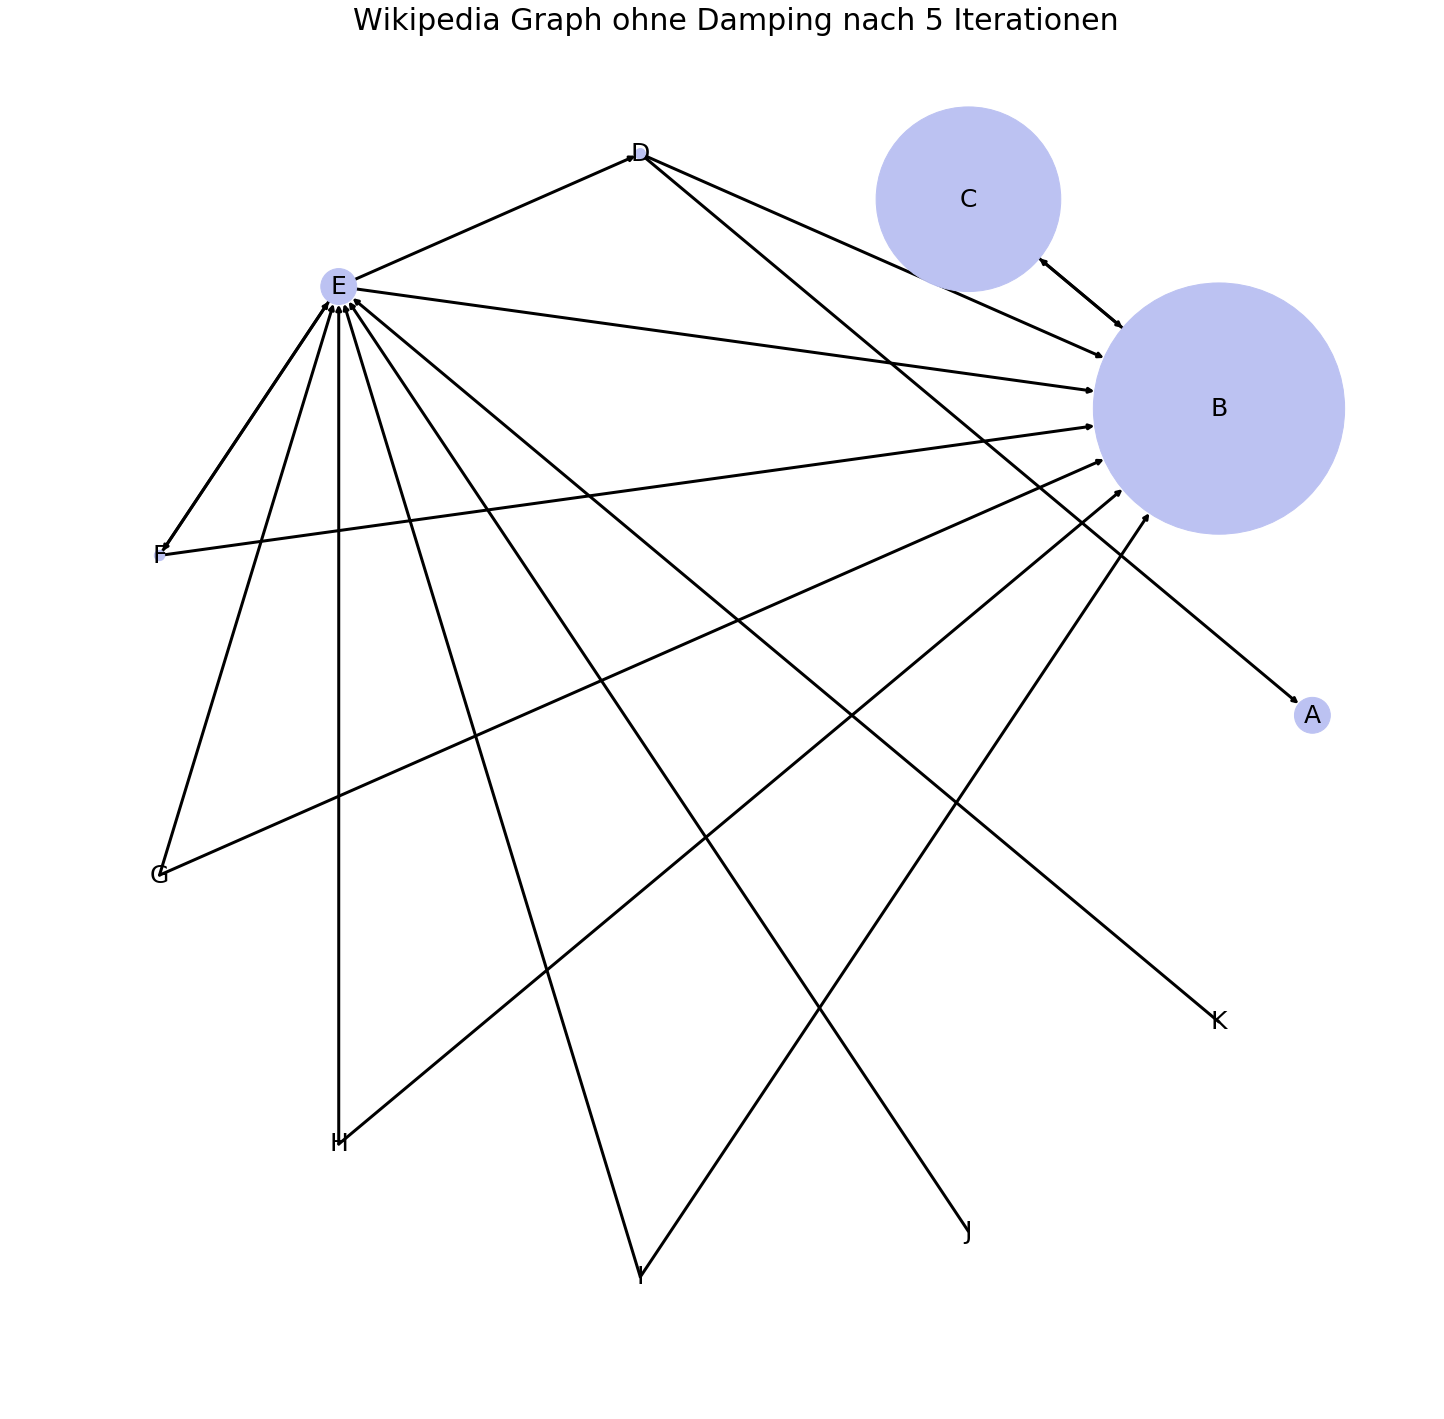

In [8]:
# Visualisierung der PageRank Werte ohne Dämpfungsfaktor nach 5 Iterationen
pr = pageRankNoDamping(G.adjacency_matrix(), 0.85, 0.001, 5)
print('PageRank Vektor ohne Dämpfung, 5 Iterationen:')
print(pr)
T = nx.from_numpy_matrix(np.array(G.adjacency_matrix()), 
                        create_using=nx.DiGraph())
plt.figure(figsize=(25,25))
plt.title('Wikipedia Graph ohne Damping nach 5 Iterationen', fontsize=30)
nx.draw_circular(T, font_size = 25, node_size=pr*100000, labels=labeldict,
                 **options)

Erkenntnis: Der PageRank fließt nicht nur zu Senken ab, sondern hält sich auch in Subgraphen, die keine Verlinkungen nach außen haben. Besonders, wenn in diesen Teilgraphen wichtige Seiten enthalten sind, können sie sich noch schneller als eine einfache Senke PageRank zuspielen.

<a id="Frage"></a>
<br>

## 7. Frage: Warum hat derselbe Graph auf Wikipedia zwei verschiedene PageRank-Vektoren?

In [9]:
# Frage: Warum haben die Knoten des gleichen Graphen auf der deutschen bzw. englischen 
# Wikipdia Seite leicht verschiedene PageRanks?
# Algorithmus von !Wikipedia! mit kleineren Anpassungen. 
# Vorsicht: Der Wikipedia-Algorithmus rechnet mit spaltenstochastischer Matrix.
# Antwort: Der PageRank Vektor im deutschen Artikel wurde nicht normiert.
# [Q1]
def wiki_pagerank(A, eps=1.0e-8, d=0.85):
    
    #in spaltenstochastische Matrix umwandeln
    M = Matrix(QQ, A)

    for index in range(M.nrows()):
        s = sum(M[index])
        if s != 0:
            M[index] = M[index] / s
    M = M.transpose()
             
    N = M.nrows()
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    last_v = np.ones((N, 1), dtype=np.float32) * 100

    while np.linalg.norm(v - last_v, 2) > eps:
        last_v = v
        v = d * np.matmul(M, v) + ((1 - d) / N)
    
    print('Deutscher Wiki-PageRank-Vektor:')
    print(v.T)
    print('Englischer Wiki-PageRank-Vektor (normiert):')
    print((v / sum(v)).T)

wiki_pagerank(G.adjacency_matrix())

Deutscher Wiki-PageRank-Vektor:
[[0.02764593 0.32418058 0.28918986 0.0329637  0.06821412 0.0329637
  0.01363636 0.01363636 0.01363636 0.01363636 0.01363636]]
Englischer Wiki-PageRank-Vektor (normiert):
[[0.03278149 0.38440095 0.34291029 0.03908709 0.08088569 0.03908709
  0.01616948 0.01616948 0.01616948 0.01616948 0.01616948]]


<a id="Twitter"></a>
<br>

## 8. Anwendung: Twitter Influencer
Von den Google-Gründern zum Webseiten-Sortieren erntwickelt, lässt sich PageRank leicht auf verschiedene Probleme anwenden, für die die Wichtigkeit von Objekten bestimmt werden muss. Beispielsweise das Ranking von wissenschaftlichen Papern, Autoren und Magazinen, Ergebnissen der Bildersuche, Straßen nach Verkehrsfluss und biochemischen Reaktionen im Metabolismus sind mit PageRank möglich. [Q3] Gute Gründe für den Einsatz von PageRank sind Einfachheit, Allgemeinheit und schnelle Berechnung.
Hier soll der PageRank beispielhaft auf ein kleines Netzerk von Influncern angewendet werden.

In [10]:
# Anwendung des PageRank-Algorithmus auf Twitter:
# Bestimmung der relevantesten Youtuberinnen
# Personen über diese Seite ausgewählt:
# https://fivmagazine.de/youtuberinnen-bibibeautypalace-shirin-david-xlaeta/

# Zum Zugriff auf die Twitter API wurde Tweepy verwendet
# Mit folgendem Code haben wir die Daten geladen, in eine Adjazenzmatrix 
# verwandelt und in eine csv Datei geschrieben. Nach der Ausführung wurden
# die API-Zugangsschlüssel entfernt, weshalb der Code so nicht mehr 
# ausführbar ist. (Außerdem dauert der Download lange, weil die Twitter 
# API nur wenige Zugriffe pro Minute zulässt, deshalb sollte er nicht mit
# jedem Restart neu ausgeführt werden)

# auth = tweepy.OAuthHandler(..., ...)
# auth.set_access_token(..., ...)
# api = tweepy.API(auth)

# Twitter ids
ids = ['dagibee', 'BibisBeauty', 'Katja_Bitch', 'MelinaSophie', 'mrsbellala', 'beautypeachiii',
      'nilamfarooq', 'PaolaMariaONE', 'tamtambeauty', 'tiinytii', 'xLaeta', 'ShirinDavid',
      'annamaria', 'lamiyaslimani']

# Textuelle Twitter ids in numerische umwandeln
# ids_num = []
# for index in range(len(ids)):
#    ids_num.append(api.get_user(ids[index]).id)

# Zu jedem Influencer die numerischen ids der Freunde herunterladen
# friends = []
# for index in range(len(ids)):
#     f = []
#    print(index)
#    for page in tweepy.Cursor(api.friends_ids, id = ids[index]).pages():
#        f = f + page
#        time.sleep(60)
        
#    friends.append(f)

In [11]:
# Adjazenzmatrix erstellen und in csv Datei schreiben
# n = len(ids)
# A = np.zeros((n, n))

# Wenn Influencer Nummer i Influncer j folgt, dann setze A[i][j] = 1
# for i in range(n):
#     for j in range(n):
#        if ids_num[j] in friends[i]:
#            A[i][j] = 1   
            
# df = pd.DataFrame(A)
# df.to_csv('Beauty_Friends.csv')

PageRank-Vektor für Influencer:
['dagibee', 'BibisBeauty', 'Katja_Bitch', 'MelinaSophie', 'mrsbellala', 'beautypeachiii', 'nilamfarooq', 'PaolaMariaONE', 'tamtambeauty', 'tiinytii', 'xLaeta', 'ShirinDavid', 'annamaria', 'lamiyaslimani']
[0.14504231 0.11153254 0.01065757 0.11081605 0.07387679 0.06543063
 0.04705723 0.07941239 0.03147605 0.0373449  0.04142925 0.10049701
 0.05904546 0.08638183]


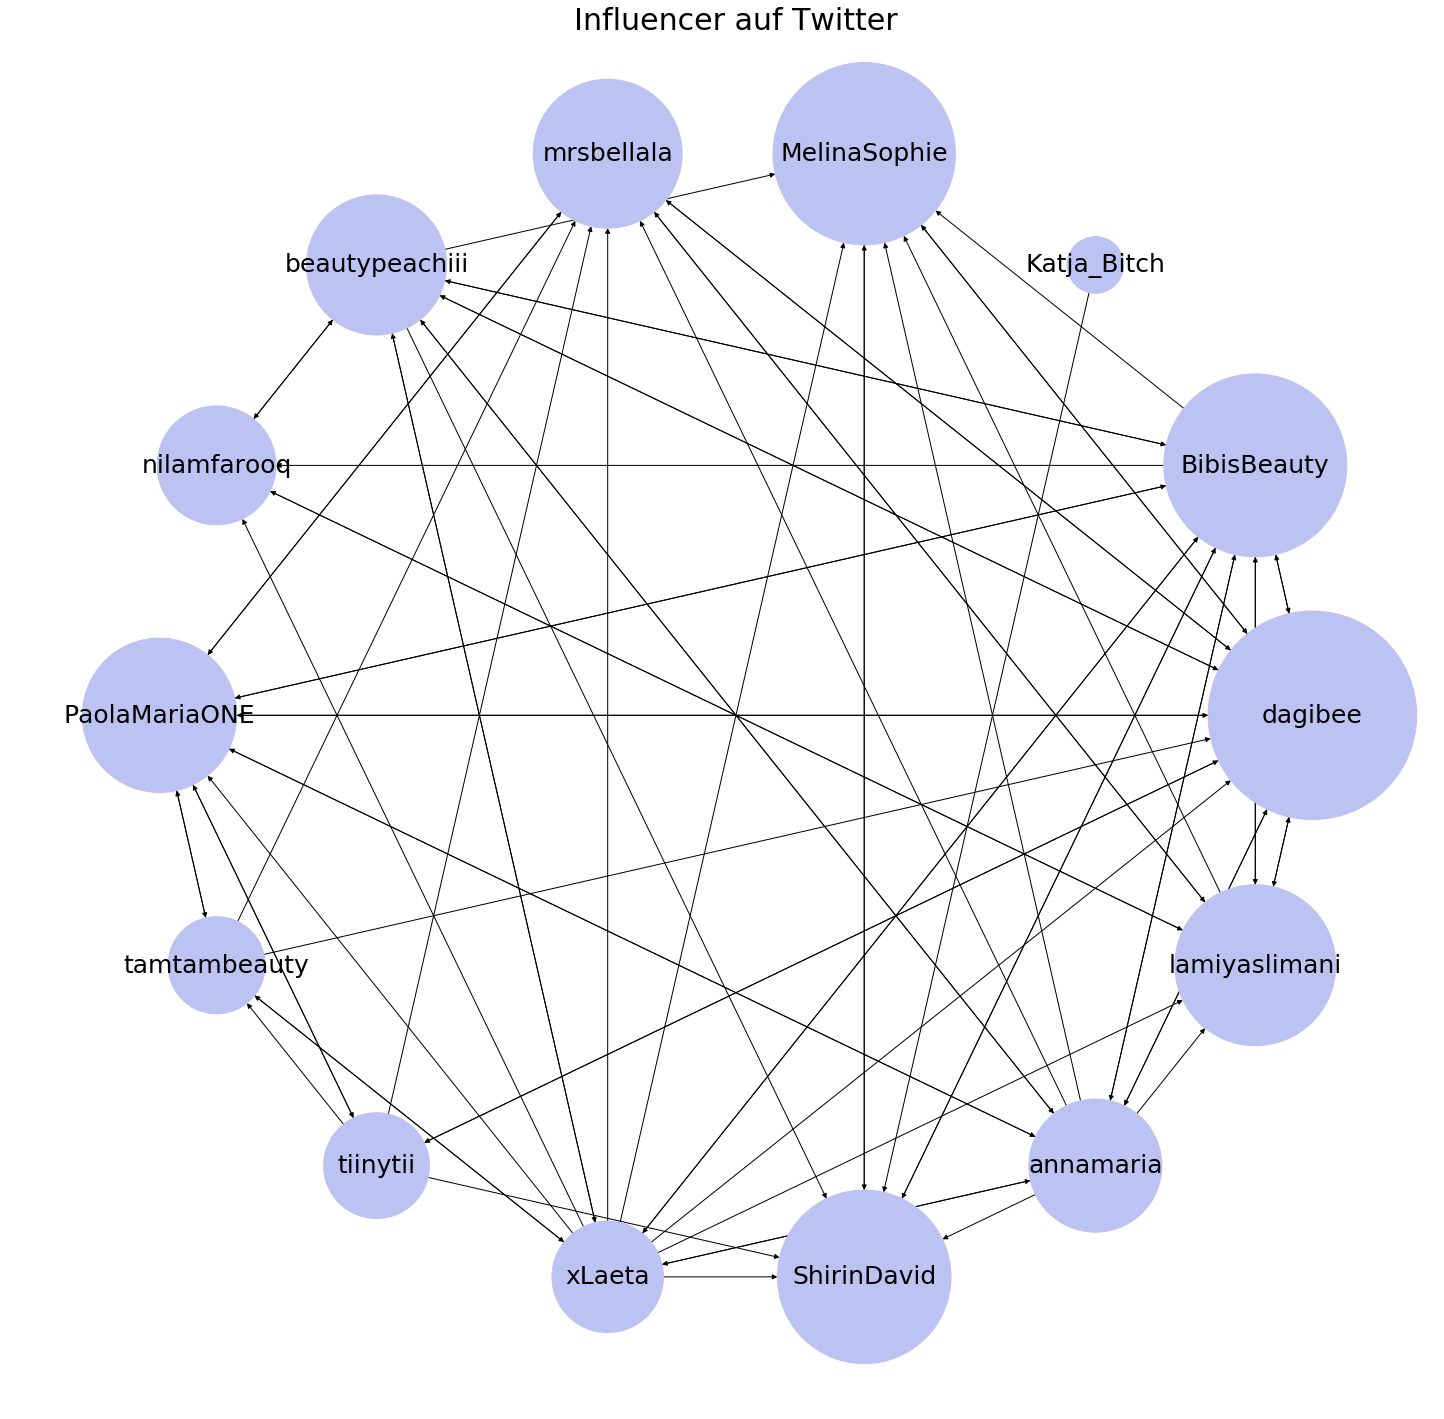

In [12]:
# Darstellung des Twitter Netzwerk-Graphen mit nach dem Pagerank 
# skalierten Knotengrößen

# Einlesen der csv Datei
# Die 0. Spalte muss gelöscht werden, da diese beim Schreiben ungewollt 
# hinzugefügt wurde
df = pd.read_csv('Beauty_Friends.csv')
A = np.delete(df.values, 0, 1)
n = len(ids)
pr = pageRank(A, 0.85, 0.001)

H = nx.DiGraph()
labeldict = {}

for index in range(n):
    H.add_node(index, nodesize=pr[index])
    labeldict[index] = ids[index]

for i in range(n):
    for j in range(n):
        if A[i][j] == 1:
            H.add_edge(i, j)
            
plt.figure(figsize=(25,25))
plt.title('Influencer auf Twitter', fontsize=30)
options = {
    #'edge_color': '#FFDEA2',
    'node_color': '#BCC2F2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}

print('PageRank-Vektor für Influencer:')
print(ids)
print(pr)
nx.draw_circular(H, labels =labeldict, font_size = 25, 
                 node_size = pr*300000, **options)

<a id="Effizienz"></a>
<br>

## 9. Effizienz 
Zur Berechnung des PageRanks für alle Internet-Seiten wird eine riesige Übergangsmatrix benötigt. Der Speicherbedarf steigt hierbei wegen der zwei Matrixdimensionen quadratisch an. Allerdings ist diese Übergangsmatrix sehr dünn besetzt, da die meisten Seiten nur auf wenige weitere Seiten verlinken. Das bedeutet, dass optimalerweise nur die Einträge und ihre Position in der Matrix gespeichert werden sollten - der Rest ist implizit mit Nullen aufgefüllt. Durch die Verwendung dieser Speicherweise kann der Rechenaufwand in Abhängigkeit von der Zahl der Webseiten linear gehalten werden. Außerdem können in diesem Format auch viele Matrixoperationen mit geringerem Rechenaufwand durchgeführt werden. In SciPy stehen Implementierungen einer solchen Matrix in scipy.sparse zur Verfügung. Die dünn besetzten Matrizen in SciPy sind auf unterschiedliche Operationen optimiert und sollten außerdem nur mit SciPy kompatiblen Funktionen verwendet werden, um die Effizienzvorteile tatsächlich zu erhalten.

In [13]:
# Speicher- und recheneffizientere Version des Algorithmus durch 
# Verwendung von einer Compressed Sparse Row Matrix zur Speicherung 
# der Übergangsmatrix
def pageRank_efficient(A, d, converge_limit):
    # Wandele A in eine Compressed sparse row matrix um.
    # Vorteile: Effiziente Matrix-Vektor-Multiplikation.
    M = sp.sparse.csr_matrix(A, dtype= sp.float32)
    
    # Umwandeln in zeilenstochastische Matrix:
    # Dazu Berechnen der Zeilensummen und der Nullzeilen. Beide 
    # Operationen sind mit csr Matrizen sehr effizient.
    # Dann alle nicht-null-Zeilen normieren.
    row_sums = np.array(M.sum(int(1)))[:,0]
    rows_non_zero,... = M.nonzero()
    M.data = M.data / row_sums[rows_non_zero]

    M = M.T
    n = M.shape[0]
    pr = np.ones((n), dtype=sp.float32)
    pr_old = np.zeros(n)

    while sp.sum(np.abs(pr - pr_old)) > converge_limit:
        pr_old = pr
        # Effizientere Matrix-Vektor Multiplikation
        pr = d * M.dot(pr) + (1-d)/n
    print('PageRank Vektor für Graph G:')
    print(pr/sp.sum(pr))
pageRank_efficient(G.adjacency_matrix(),0.85,0.001)

PageRank Vektor für Graph G:
[0.03272704 0.38485977 0.34290448 0.03902216 0.08075133 0.03902216
 0.01614262 0.01614262 0.01614262 0.01614262 0.01614262]


<a id="Iterationen"></a>
<br>

## 10. Iterationen in Abhängigkeit von der Genauigkeit

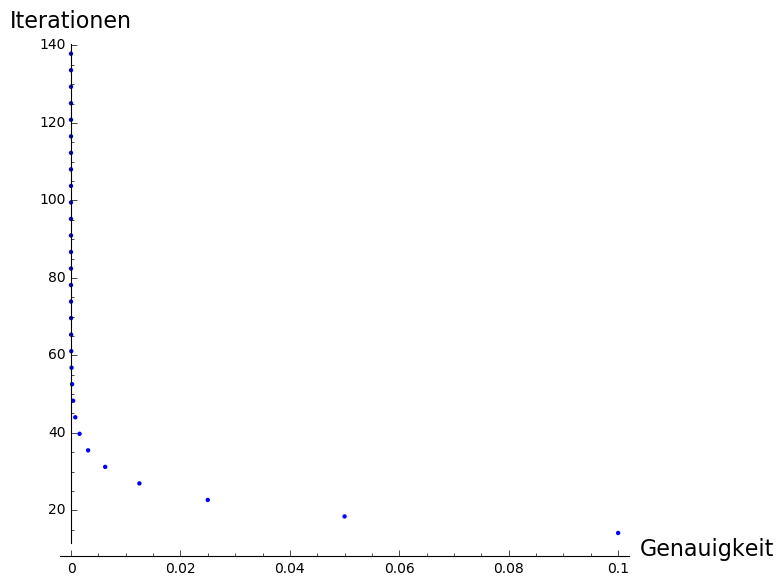

In [14]:
#Funktion zum Anzeigen der Anzahl von Iterationen, die benötigt werden um
#ein Ergebnis im Rahmen, der festgelegten Abweichung zu bekommen.
#Hier in Abhängigkeit des Converge-Limits.
#Je präziser das Ergebnis, desto mehr Iterationen sind nötig.
def iterateCompareConverge(d, converge_limit):
    converge_it = []
    converge_start = 1.0e-1

    
    while converge_start > converge_limit:
        iterations = log(converge_start,10)/log(d,10)        #[Q5]
        converge_it.append((converge_start,iterations))
        converge_start = converge_start /2
        
    return converge_it;

tmp = iterateCompareConverge(0.85, 1.0e-10)   
points = []
y = []
for i in range(len(tmp)):
    points.append(tmp[i])
    y.append(tmp[i][0])

#Zeigt die Iterationen in Abhängigkeit der Genauigkeit.
show(list_plot(points,aspect_ratio='automatic',axes_labels=['Genauigkeit','Iterationen']))

<a id="Eigenschaften"></a>
<br>

## 11. Eigenschaften des PageRanks

Vorteile:
- Einfacher Algorithmus, leicht auf viele Probleme anwendbar
- Seiten, die auf $n$ Seiten verlinken geben jeder dieser Seiten $\frac{1}{n}$ ihres PageRanks (abgesehen von Dämpfung), somit hat jede Seite insgesamt genau eine Stimme 

Nachteile:
- Da nur Verlinkungen von Websites einbezogen werden (Konzept der Linkpopularität) und nicht Nutzer des Internets, kann der PageRank relativ stark von der tatsächlichen Beliebtheit bei Internetnutzern abweichen
- Durch das Konzept der Linkpopularität wird ebenfalls der qualitative Inhalt einer Seite vernachlässigt
- Der PageRank in seiner Ursprungsform kann leicht durch Linkfarmen, die für Geld auf bestimmte Seiten verlinken und Communities, die sich untereinander verlinken manipuliert werden
- Alte Seiten werden bevorzugt, da auf neue Seiten wenige Links zeigen



PageRank-Vektor für D1:
[0.25323896 0.24525312 0.23846515 0.23309181 0.02995096]
PageRank-Vektor für D2:
[0.47019868 0.13245033 0.13245033 0.13245033 0.13245033]


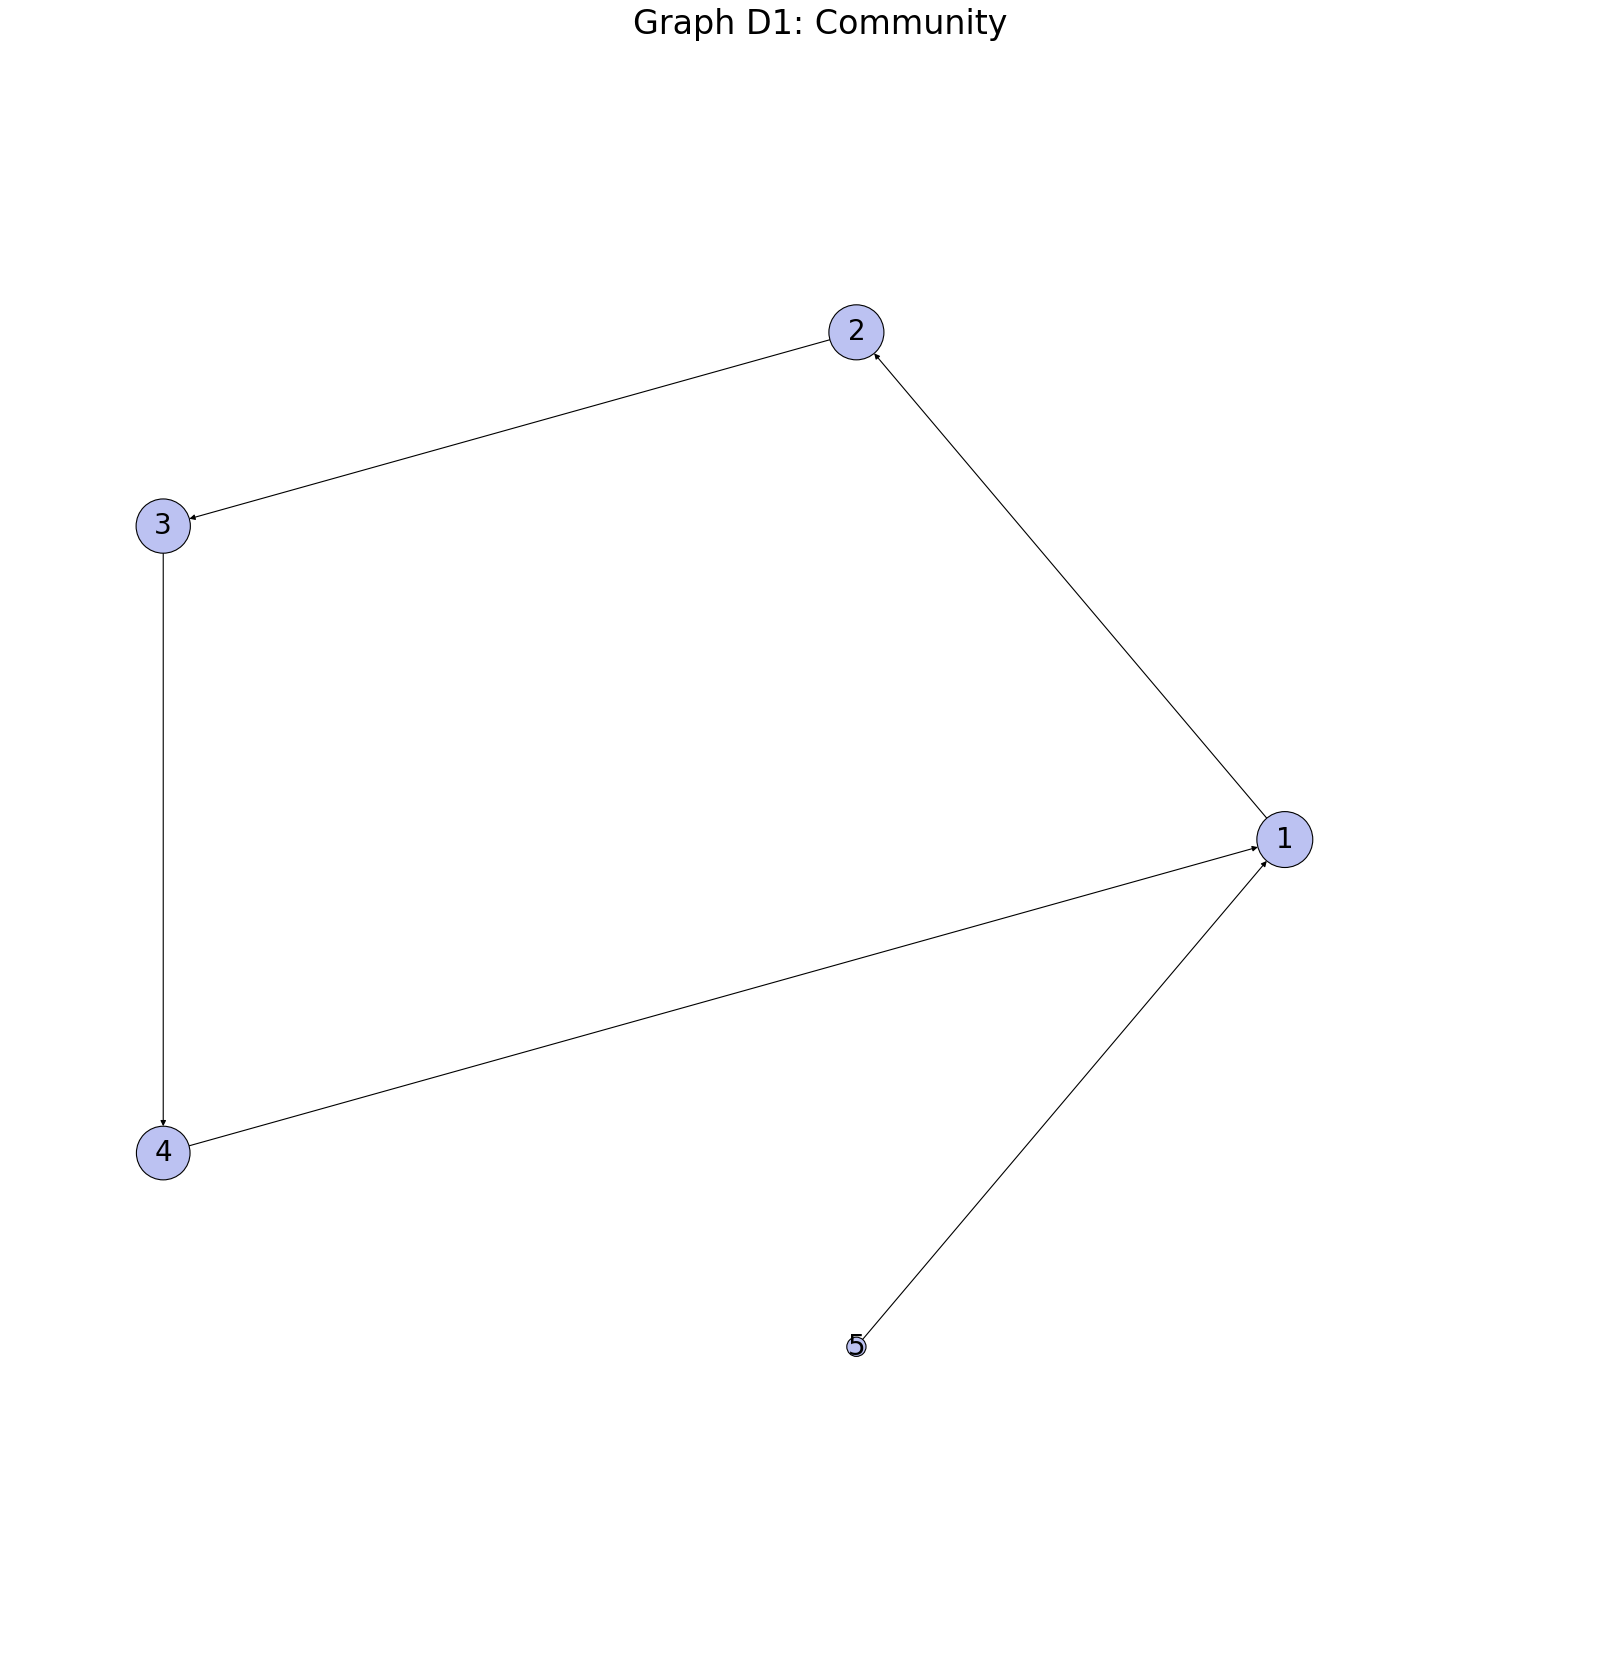

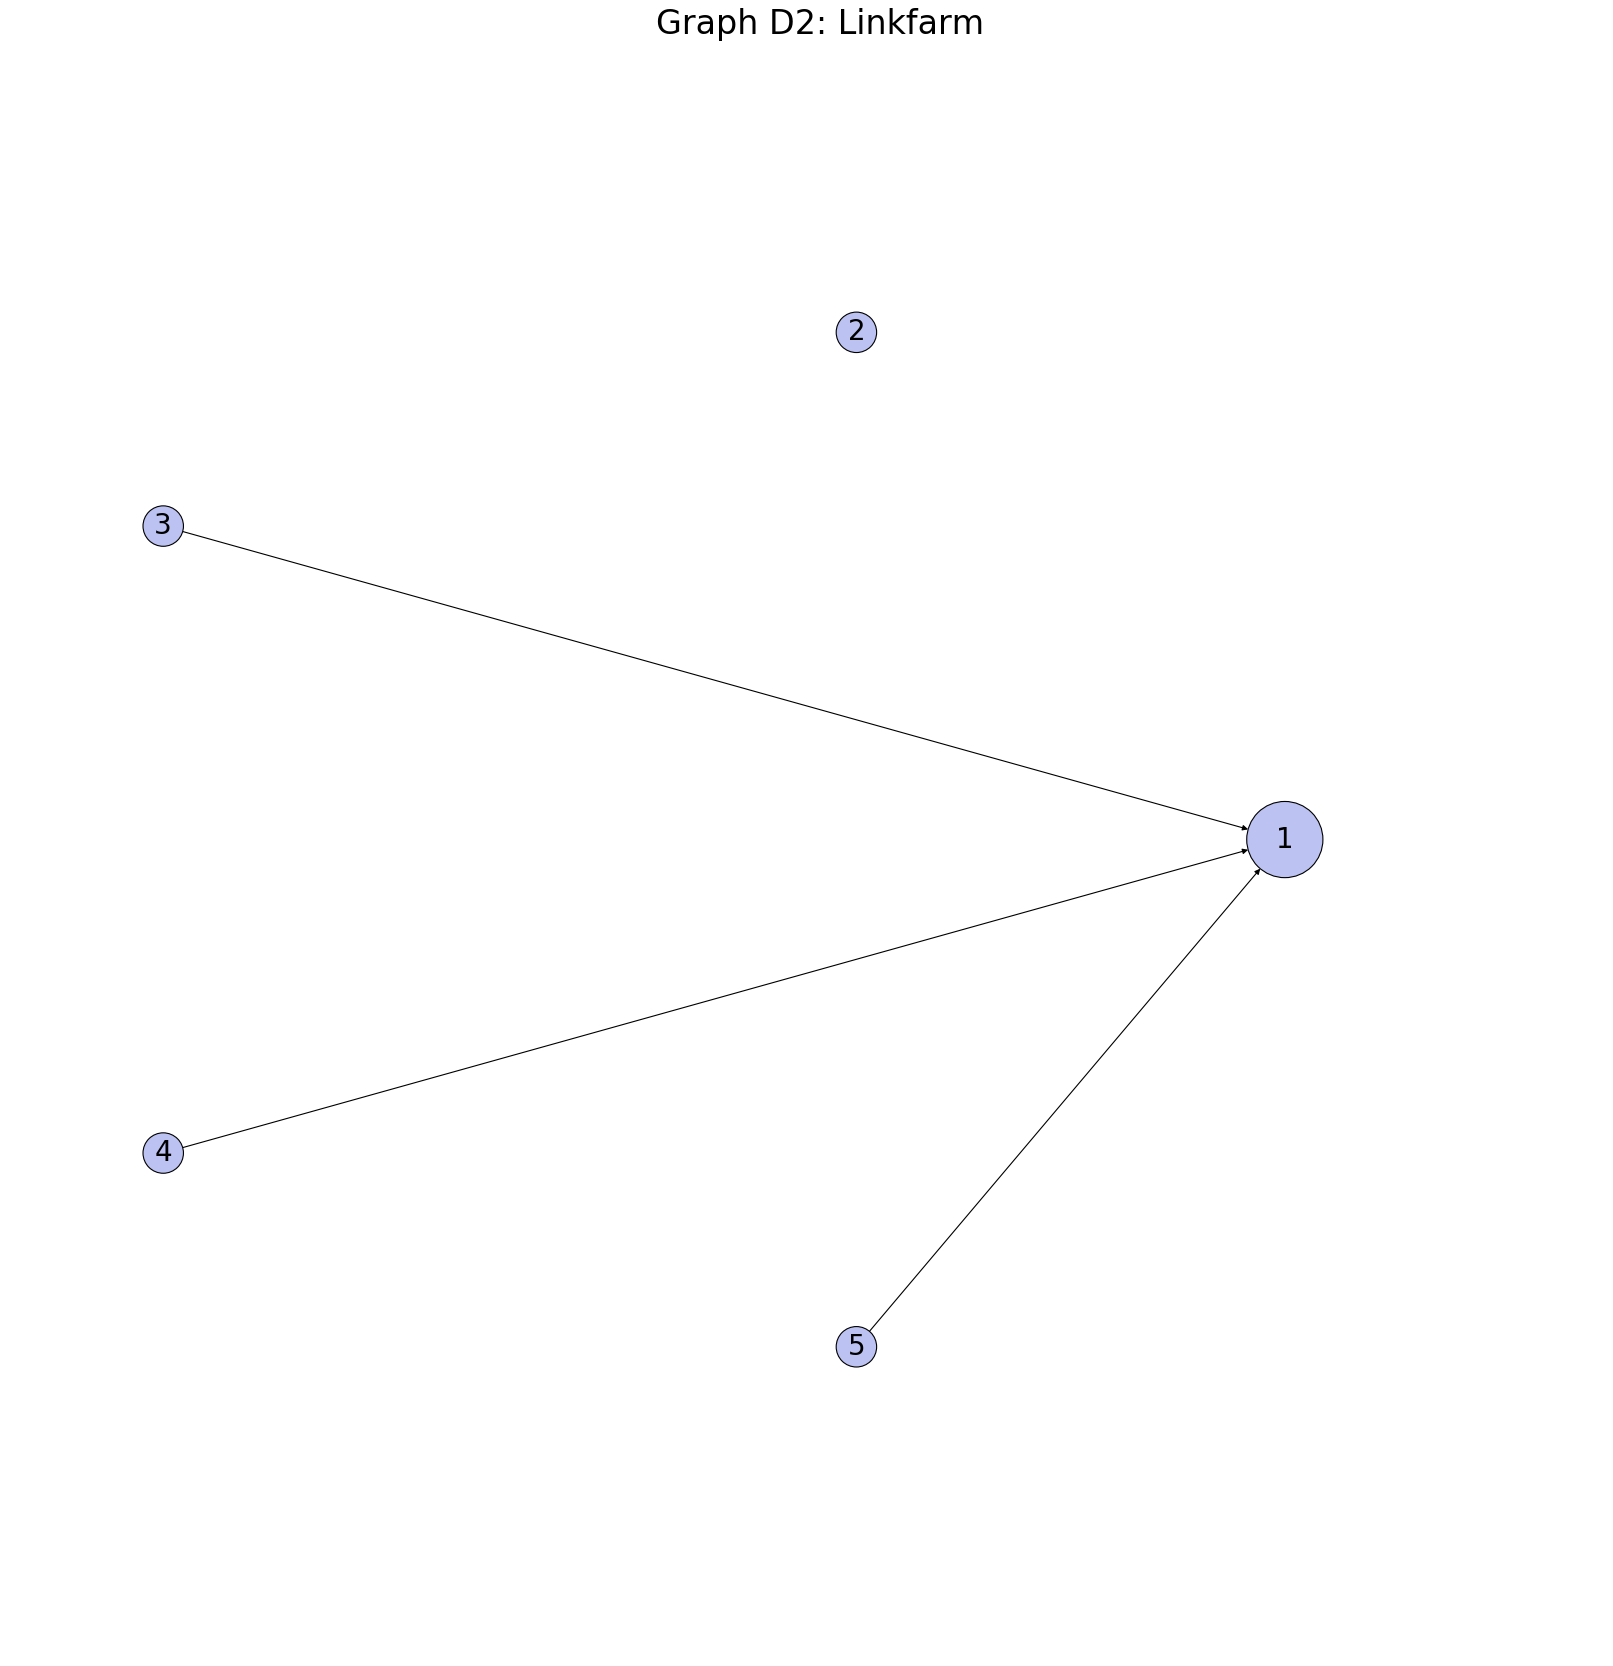

In [15]:
# Demonstration der Verteilung des PageRanks in kleinen Graphen
# 1. Community, die untereinander auf sich verlinkt und Außenseiter.
D1 = nx.DiGraph()
D1.add_nodes_from([1,2,3,4,5])
D1.add_edges_from([(1,2), (2,3), (3,4), (4,1), (5,1)])
        
pr = pageRank(nx.adjacency_matrix(D1).todense(),0.85,0.001)
print('PageRank-Vektor für D1:')
print(pr)
plt.figure(figsize=(25,25))
plt.title('Graph D1: Community', fontsize=30)
nx.draw_circular(D1, font_size = 25, node_size=pr*10000, label='Graph D1'
                 ,**options)

# 2. Linkfarm erstellt viele Websites, die auf die eines Kunden verlinken
# (Hier stehen Knoten 3, 4 und 5 für solche Linkfarm_websites, die das Gesamt-
# bild verzerren)
                 
D2 = nx.DiGraph()
D2.add_nodes_from([1,2,3,4,5])
D2.add_edges_from([(3,1), (4,1), (5,1)])

pr = pageRank(nx.adjacency_matrix(D2).todense(),0.85,0.001)
print('PageRank-Vektor für D2:')
print(pr)
plt.figure(figsize=(25,25))
plt.title('Graph D2: Linkfarm', fontsize=30)
nx.draw_circular(D2, font_size = 25, node_size=pr*10000, **options)

<a id="Quellen"></a>
<br>

## 12. Quellenverzeichnis
**Index** &emsp;&ensp; **Quelle** <span style="display:inline-block; width:348px;"></span> **zuletzt geöffnet**<br>
[Q0] &emsp;&emsp; https://en.wikipedia.org/wiki/File:PageRanks-Example.svg &emsp;&emsp; (06.06.2019)<br>
[Q1] &emsp;&emsp; https://en.wikipedia.org/wiki/PageRank &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; (13.06.2019)<br>
[Q2] &emsp;&emsp; https://arxiv.org/pdf/1407.5107.pdf &ensp; Abschnitt 2.1  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; (13.06.2019)<br>
[Q3] &emsp;&emsp; https://www.nature.com/articles/srep16181  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; (13.06.2019)<br>
[Q4] &emsp;&emsp; Jenny Tjan,"How to optimize the personalization vector to combat link spamming" in "Report for the Delft Institute of Applied Mathematics", 2016<br>
[Q5] &emsp;&emsp; Amy N.Langville und Carl D. Meyer, "Deeper Inside PageRank" in "Interet Mathematics Vol.1, No.3, 2004